In [2]:
import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
import cv2

from tqdm.auto import tqdm

In [2]:
import torch
import gc

def clear_gpu(is_del=False):
    # Delete all variables referencing GPU tensors
    gc.collect()  # Force garbage collection
    torch.cuda.empty_cache()  # Free cached memory

    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()

    if (is_del):
        for obj in gc.get_objects():
            if torch.is_tensor(obj) and obj.is_cuda:
                del obj
        gc.collect()
        torch.cuda.empty_cache()

    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()


def check_gpu_objects():
    gpu_tensors = [obj for obj in gc.get_objects() if torch.is_tensor(obj) and obj.is_cuda]
    print(f"Number of GPU tensors: {len(gpu_tensors)}")
    for i, tensor in enumerate(gpu_tensors[:5]):  # Print only the first 5
        print(f"Tensor {i}: {tensor.size()}, {tensor.dtype}, {tensor.device}, {tensor.numel()*tensor.element_size()/2**20}MB")

check_gpu_objects()
# clear_gpu(True)

Number of GPU tensors: 0


/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/__init__.py:1113: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


### Initializations

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import sys
sys.path.append('../DataSetLoaders')
from ChessRec_Dataset import ChessRecDataset, img_transform
dataset = ChessRecDataset(label_key="corners", transform_fn=img_transform(is_color=False))
dataloader = dataset.getLoader()
len(dataset)

2078

(3024, 3024, 3)

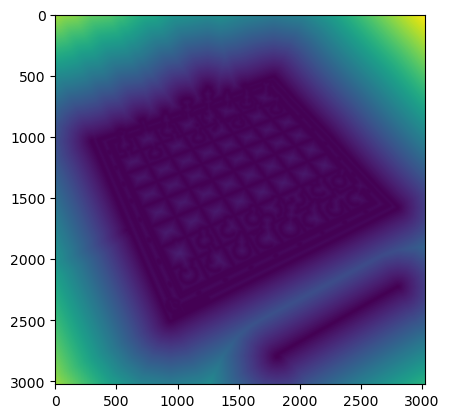

In [5]:
image_file_path = "../data/image_0.jpg"
img = np.array(Image.open(image_file_path))
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img_blur = cv2.GaussianBlur(img_gray, (3, 3), 1)
img_edge = cv2.Canny(img_gray, 100, 700)
d = torch.tensor(cv2.distanceTransform(255-img_edge, cv2.DIST_L2, 5))
plt.imshow(d.cpu());
# plt.imshow(img_edge);
img.shape

### Error fn Model
- Warp Matrix computation
- Grid Coordinates generation
- Warp Applying
- Cosines Board Model
- Error Calculation - Distance Transform

In [7]:
src_pts = torch.tensor([
    [0,0],
    [255,0],
    [255,255],
    [0,255],
], dtype=torch.float32)

def get_M(dst_pts: torch.Tensor) -> torch.Tensor:
    # assert src_pts.shape == (4, 2) and dst_pts.shape == (4, 2), "Source and destination points must be (4,2)"
    r_blk_x = -(src_pts * dst_pts[:,[0]])
    r_blk_y = -(src_pts * dst_pts[:,[1]])

    A_1 = torch.cat([src_pts, torch.ones(src_pts.shape[0], 1), torch.zeros(src_pts.shape[0], 3), r_blk_x], dim=1)
    A_2 = torch.cat([torch.zeros(src_pts.shape[0], 3), src_pts, torch.ones(src_pts.shape[0], 1), r_blk_y], dim=1)
    A = torch.stack([A_1, A_2], dim=1).reshape(8, 8)

    B = dst_pts.flatten().to(torch.float32)

    # # Solve Ax = B using torch.linalg.lstsq
    # X = torch.linalg.lstsq(A, B).solution[:8]
    # Solve Ax = B using torch.linalg.solve (instead of lstsq)
    X = torch.linalg.solve(A, B)


    # Reshape to form 3x3 matrix
    M = torch.cat([X, torch.tensor([1.0])], dim=0).reshape(3, 3)

    return M

def get_grid(grid_size=256) -> torch.Tensor:
    H, W = grid_size, grid_size

    # Create coordinate grids
    x_coords = torch.arange(W).view(1, W).expand(H, W)
    y_coords = torch.arange(H).view(H, 1).expand(H, W)

    # Stack to form (W, H, 2)
    return torch.stack((y_coords, x_coords), dim=-1).to(torch.float32)  

def warp_coordinates(coords: torch.Tensor, M) -> torch.Tensor:
    """Warp (x', y') back to (x, y) using the inverse transform."""
    W, H = coords.shape[0], coords.shape[1]  # Extract dimensions

    expanded_coords = torch.cat([coords, torch.ones_like(coords[:,:,[0]])], dim=2)

    # Reshape coords from (3, W, H) → (3, W*H) for matrix multiplication
    # coords_flat = t.permute(2,0,1).view(3, W*H)  # Shape (3, W*H)
    coords_flat = expanded_coords.flatten(0,1).T  # Shape (3, W*H)

    # Perform matrix multiplication
    warped = (M @ coords_flat).T.unflatten(0, (W,H)).permute(1,0,-1)  # Shape (3, W*H)

    return warped / warped[:,:,[2]]

def reverseWarp_coordinates(coords: torch.Tensor, M): # M is the inversing one
    return warp_coordinates(coords, M.inverse())

def warp_points(pts, M):
    return warp_coordinates(src_pts.unsqueeze(0), M).squeeze().to(torch.int)

def chessboard(coords: torch.Tensor) -> torch.Tensor:
    p = 100
    out = (torch.relu(torch.cos((np.pi/16) * coords[:,:,0]))) ** p + (torch.relu(torch.cos((np.pi/16) * coords[:,:,1]))) ** p

    out[torch.logical_or(coords[:,:,0] < 0, coords[:,:,0] >= 256)] = 0
    out[torch.logical_or(coords[:,:,1] < 0, coords[:,:,1] >= 256)] = 0

    return out

def calcError(d: torch.Tensor, warpped: torch.Tensor) -> torch.Tensor:
    return torch.mean(d**2 * warpped)

def rectify_boundaries(dst: torch.Tensor, img_size: int) -> bool:
    if ((dst < 0).any() or (dst >= img_size).any()):
        return True
    
    half_image = img_size // 2

    if (dst[0][0] > half_image or dst[0][1] > half_image):
        return True
    if (dst[1][0] < half_image or dst[1][1] > half_image):
        return True
    if (dst[2][0] < half_image or dst[2][1] < half_image):
        return True
    if (dst[3][0] > half_image or dst[3][1] < half_image):
        return True
    
    return False

def calcError_from_M(d: torch.Tensor, M: torch.Tensor):
    img_size = d.shape[0]

    d_device = d.device

    grid = get_grid(img_size)
    new_coords = warp_coordinates(grid, M.inverse())[:,:,:2]
    warpped = chessboard(new_coords)
    loss = calcError(d, warpped.to(d_device))

    if (rectify_boundaries(warp_points(src_pts, M), img_size)):
        loss += 1e5
    
    return loss, warpped

def calcError_from_dst(d: torch.Tensor, dst: torch.Tensor):
    M = get_M(dst)
    return calcError_from_M(d, M)

### Example Test

In [11]:
# dst = torch.tensor([
#     [720,920],
#     [2264,935],
#     [2634,2217],
#     [470,2237],
# ], dtype=torch.float32)

dst = torch.tensor([
    [464, 1055],
    [1747, 613],
    [2586, 1537],
    [1039, 2279],
], dtype=torch.float32)

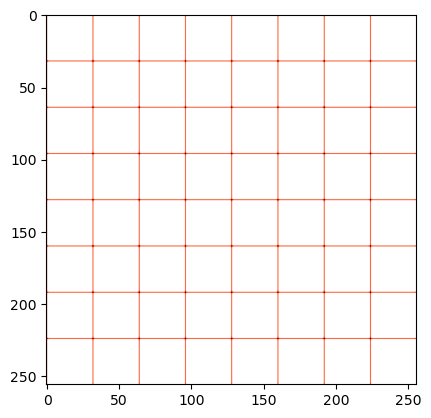

In [12]:
grid = get_grid(256)
board = chessboard(grid)
plt.imshow(board, alpha=(board>.5).float(), cmap='Reds');

tensor([[ 464., 1055.],
        [1747.,  613.],
        [2586., 1537.],
        [1039., 2279.]])


tensor(0.9071)

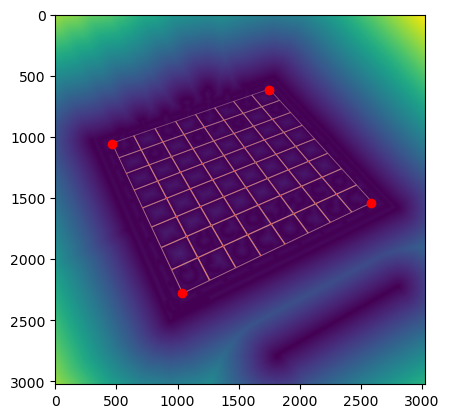

In [13]:
# %%timeit

# loss = calcError_from_dst(d, dst)

def show_grid(d, dst=None, M=None):
    if not(dst is None):
        M = get_M(dst)
    elif M is None:
        raise ValueError("Either dst or M must be provided")
    
    loss, warpped = calcError_from_M(d, M)

    plt.imshow(d.cpu());
    plt.imshow(warpped, alpha=(warpped>.5).float(), cmap='Reds');
    if (dst is None):
        dst = warp_points(src_pts, M)[:,:2]

    plt.scatter(dst[:,0], dst[:,1], c='red');
    print(dst)
    return loss

show_grid(d, dst=dst)

### DNN dst corner pts prediction

In [10]:
H, W = 3024, 3024

class BoardDetector(nn.Module):
    def __init__(self, I_Shape=(W, H)):
        super().__init__()

        self.I_shape = I_Shape
        self.I_Size = I_Shape[0] * I_Shape[1]
        
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 5, 3, 1, 1),
            nn.ELU(),
            nn.BatchNorm2d(5),
            nn.MaxPool2d(4),

            nn.Conv2d(5, 8, 3, 1, 1),
            nn.ELU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(4),

            nn.Conv2d(8, 5, 3, 1, 1),
            nn.ELU(),
            nn.BatchNorm2d(5),
            nn.MaxPool2d(4),

            nn.Conv2d(5, 1, 3, 1, 1),
            nn.ELU(),
            nn.BatchNorm2d(1),
            nn.MaxPool2d(4),
        )

        self.linear_stack = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(11*11, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = self.linear_stack(self.conv_blocks(x)).view(x.shape[0], 4, 2)
        # return self.conv_blocks(x)
        res[:,0] *= H
        res[:,1] *= W
        return res

In [7]:
# %%timeit

x = torch.rand(1, 1, 3024,3024)
bd = BoardDetector()
y = bd(x)
# y = bd(d.unsqueeze(dim=0))
y.shape, y, torch.tensor(img).to(torch.float32).mean(dim=2).shape

NameError: name 'img' is not defined

In [8]:
clear_gpu(True)

/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/cuda/memory.py:417: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [24]:
clear_gpu(True)

# bd = BoardDetector().to(device)
iter_count = 0
for X, y in dataloader:
    # x = (X/255).to(torch.float32).mean(dim=3).unsqueeze(1).to(device)
    # y_prime = bd(x)
    print(X.shape, X.dtype)
    print(y.shape, y.dtype)
    break
    x = torch.mean(X.to(torch.float32), dim=3).unsqueeze(1).to(device)
    y_prime = bd(x)
    print(y_prime.shape)
    del x,y_prime,X,y
    clear_gpu(True)
    break

    iter_count += 1
    if (iter_count == 10):
        break

torch.Size([8, 1, 3024, 3024]) torch.float32
torch.Size([8, 4, 2]) torch.float32


In [ ]:
# train_device = device
train_device = "cpu"

def train_loop(bd):
    # loss_fn = calcError_from_dst
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(bd.parameters(), lr=1e-3)

    iter = 0
    for X, y in tqdm(dataloader):
        clear_gpu()

        if (iter % 2 == 0):
            X = X.to(train_device)
            y = y.to(train_device)

            y_prime = bd(X)
            # loss = loss_fn(d, y_prime)
            loss = loss_fn(y_prime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.inference_mode():
                X = X.to(train_device)
                y = y.to(train_device)

                y_prime = bd(X)
                # loss = loss_fn(d, y_prime)
                loss = loss_fn(y_prime, y)

        if (iter % 10 == 0):
            print(f"Iteration: {iter} | Loss: {loss}")
        
        iter += 1

bd = BoardDetector().to(train_device)
train_loop(bd)

  0%|          | 0/260 [00:00<?, ?it/s]

/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/mostafaelfaggal/.local/lib/python3.12/site-packages/torch/cuda/memory.py:417: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


### Epoch Minimization

In [118]:
def denormalize_dst(dst, H, W):

    dst_out = torch.zeros_like(dst)

    dst_out[:,0] = dst[:,0] * W/2
    dst_out[:,1] = dst[:,1] * H/2

    dst_out[1:3,0] += W/2
    dst_out[2:4,1] += H/2
    
    return dst_out

In [37]:
from scipy.optimize import minimize

H,W = 3024, 3024

def loss_fn(M):
    M = torch.tensor(M, dtype=torch.float32).view(3,3)
    return calcError_from_M(d, M)[0].numpy()

def loss_fn_dst(dst):
    dst = torch.tensor(dst, dtype=torch.float32).view(4,2)
    dst = denormalize_dst(dst, H, W)
    return calcError_from_dst(d, dst)[0].numpy()

# x0 = torch.rand(9, dtype=torch.float32).numpy() * 5
# res = minimize(loss_fn, x0=x0, method='BFGS')
# res.x, loss_fn(res.x)

# x0 = torch.rand(8, dtype=torch.float32).numpy()
x0 = torch.tensor([.5]*8, dtype=torch.float32) + torch.rand(8, dtype=torch.float32) * 0.1
x0 = x0.numpy()
res = minimize(loss_fn_dst, x0=x0, method='BFGS')
(x0==res.x).all(), res.x, loss_fn_dst(res.x)

(True,
 array([0.5718333 , 0.5754519 , 0.5927365 , 0.5604874 , 0.571444  ,
        0.59811753, 0.50723785, 0.57382673], dtype=float32),
 array(12.817624, dtype=float32))

tensor([[0.5718, 0.5755],
        [0.5927, 0.5605],
        [0.5714, 0.5981],
        [0.5072, 0.5738]])
tensor([[ 864.6119,  870.0833],
        [2408.2175,  847.4569],
        [2376.0234, 2416.3538],
        [ 766.9436, 2379.6260]])


tensor(12.8176)

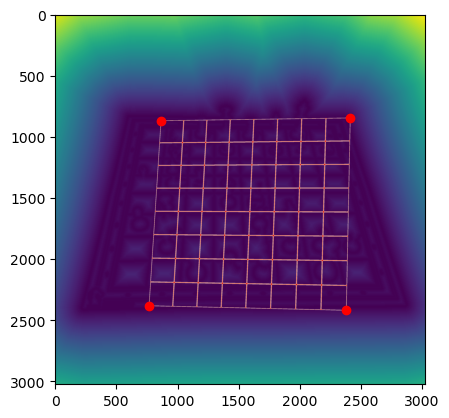

In [38]:
# M_tmp = torch.tensor(res.x, dtype=torch.float32).view(3,3)
# show_grid(d, M=M_tmp), M_tmp

dst_tmp = torch.tensor(res.x, dtype=torch.float32).view(4,2)
print(dst_tmp)
dst_tmp = denormalize_dst(dst_tmp, H, W)
show_grid(d, dst=dst_tmp)

In [153]:
start_param = (torch.tensor([.5]*8, dtype=torch.float32) + torch.rand(8, dtype=torch.float32) * 0.1).view(4,2)
best_param = start_param
best_loss = 1e10

class CEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dst = torch.nn.Parameter(start_param.clone().detach())

    def forward(self, x):
        return self.dst
    
def loss_fn(dst_prime, d):
    dst_prime = denormalize_dst(dst_prime, H, W)
    return calcError_from_dst(d, dst_prime)[0]

def train_loop(model, epochs=10, lr=1e-3):
    global best_loss, best_param
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in tqdm(range(epochs)):
        dst_prime = model(None)
        loss = loss_fn(dst_prime, d)


        if (loss < best_loss):
            best_loss = loss
            best_param = dst_prime.clone().detach()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i % 1 == 0):
            print(f"Iter {i} | Loss: {loss}")

model = CEModel()
train_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

Iter 0 | Loss: 19.393253326416016
Iter 1 | Loss: 19.344985961914062
Iter 2 | Loss: 19.34419059753418
Iter 3 | Loss: 19.30632209777832
Iter 4 | Loss: 19.248401641845703
Iter 5 | Loss: 19.14688491821289
Iter 6 | Loss: 19.02503776550293
Iter 7 | Loss: 18.864582061767578
Iter 8 | Loss: 18.67791748046875
Iter 9 | Loss: 18.464330673217773


tensor([[ 886.4543,  910.8468],
        [2374.2524,  862.4133],
        [2295.5703, 2294.8708],
        [ 778.8943, 2290.2788]])


(tensor(18.2417), tensor(18.2417))

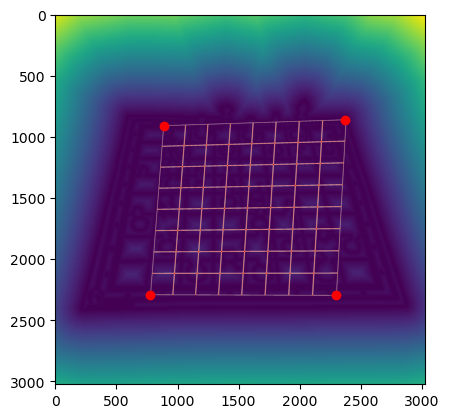

In [154]:
# print(start_param, best_param, model.dst)
# dst = start_param
# dst = best_param
dst = model.dst.detach()

dst = denormalize_dst(dst, H, W)
show_grid(d, dst=dst), calcError_from_dst(d, dst)[0]

In [52]:
x0 = torch.tensor([.5]*8, dtype=torch.float32) + torch.rand(8, dtype=torch.float32) * 0.1
x0 = torch.nn.Parameter(x0)

class CEModel(nn.Module):
    def __init__(self):
        super().__init__()
        x0 = torch.rand(3,3, dtype=torch.float32)
        self.M = torch.nn.Parameter(x0)

    def forward(self, x):
        return self.M
    
def loss_fn(M_prime, d):
    return calcError_from_M(d, M_prime)[0]

def train_loop(epochs=100, lr=1e-3):
    model = CEModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in tqdm(range(epochs)):
        M_prime = model(None)
        loss = loss_fn(M_prime, d)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i % 1 == 0):
            print(f"Loss: {loss}")

train_loop()

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 100000.0
Loss: 100000.0
Loss: 100000.0
Loss: 100000.0
Loss: 100000.0
Loss: 100000.0


KeyboardInterrupt: 

### Absolute Minimum: d/dx = 0